In [106]:
import rebound
import reboundx
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

def wrap(val):
    while val < 0:
        val += 2*np.pi
    while val > 2*np.pi:
        val -= 2*np.pi
    return val*180/np.pi

def initialize(planets, resonances, threebodyresonances):
    t, e, P, pomega, longitude, Pratio, phi1, phi2, deltapomega, phi3body = {}, {}, {}, {}, {}, {}, {}, {}, {}, {}

    for label in planets:
        t[label] = []
        e[label] = []
        P[label] = []
        pomega[label] = []
        longitude[label] = []

    for pair in resonances.keys():
        t[pair] = []
        Pratio[pair] = []
        phi1[pair] = []
        phi2[pair] = []
        deltapomega[pair] = []
        
    for triad in threebodyresonances.keys():
        t[triad] = []
        phi3body[triad] = []
        
    return t, e, P, pomega, longitude, Pratio, phi1, phi2, deltapomega, phi3body

def output(sim, time,planets,resonances,threebodyresonances,t,e,P,pomega,longitude,Pratio,phi1,phi2,deltapomega,phi3body):
    ps = sim.particles
    for p in planets:
        try:
            e[p].append(ps[p].e)
            P[p].append(ps[p].P)
            pomega[p].append(ps[p].pomega)
            longitude[p].append(ps[p].l)  
            t[p].append(time)
        except:
            pass
    for resonance in resonances.items():
        pair = resonance[0]
        p1 = pair[0]
        p2 = pair[1]
        res = resonance[1]
        p = res[1]
        q = res[0]-res[1]
        try:
            Pratio[pair].append(ps[p2].P/ps[p1].P)
            phi1[pair].append(wrap((p+q)*ps[p2].l - p*ps[p1].l - q*ps[p2].pomega))
            phi2[pair].append(wrap((p+q)*ps[p2].l - p*ps[p1].l - q*ps[p1].pomega))
            deltapomega[pair].append(wrap(ps[p2].pomega - ps[p1].pomega))
            t[pair].append(time)   
        except:
            pass
    for resonance in threebodyresonances.items():
        triad = resonance[0]
        p1 = triad[0]
        p2 = triad[1]
        p3 = triad[2]
        res = resonance[1]
        p = res[0]
        q = res[1]
        try:
            phi3body[triad].append(wrap(p*ps[p1].l - (p+q)*ps[p2].l + q*ps[p3].l))
            t[triad].append(time)
        except:
            pass
        
def plot(sa,planets,resonances,threebodyresonances):
    Nout = len(sa)
    N = sa[0].N
    
    t, e, P, pomega, longitude, Pratio, phi1, phi2, deltapomega, phi3body = initialize(planets, resonances, threebodyresonances)
    for i,sim in enumerate(sa):
        ps = sim.particles
        output(sim,sim.t,planets,resonances,threebodyresonances,t,e,P,pomega,longitude,Pratio,phi1,phi2,deltapomega,phi3body)
    
    for p in planets: # final periods
        print(p, ps[p].P)
        
    fig, axarr = plt.subplots(ncols=2, nrows=4, figsize=(18,10))
    for p in planets:
        axarr[0,0].plot(t[p], P[p], '.', label=p)
        axarr[0,1].plot(t[p], e[p], '.', label=p)
    for resonance in resonances.items():
        pair = resonance[0]
        res = resonance[1]
        resratio = res[0]/res[1]
        axarr[1,0].plot(t[pair], Pratio[pair], '.', label=pair)
        print(pair, Pratio[pair][-1])
        axarr[1,1].plot(t[pair], np.array(Pratio[pair])-resratio, '.', label=pair)
        axarr[2,0].plot(t[pair], phi1[pair], '.', label=pair)
        axarr[2,1].plot(t[pair], phi2[pair], '.', label=pair)
        axarr[3,0].plot(t[pair], deltapomega[pair], '.', label=pair)
        axarr[2,0].set_ylim([0.,360])
        axarr[2,1].set_ylim([0.,360])
    for resonance in threebodyresonances.items():
        triad = resonance[0]
        axarr[3,1].plot(t[triad], phi3body[triad], '.', label=triad)
    for ax in axarr.flatten():
        ax.legend(loc='upper left')
        
    return fig

In [107]:
from collections import OrderedDict
planets = ['b', 'c', 'd', 'e', 'f', 'g', 'h']
resonances = OrderedDict([(('b','c'),(8,5)),(('c','d'),(5,3)),(('d','e'),(3,2)),(('e','f'),(3,2)),(('f','g'),(4,3)),(('g','h'),(3,2))]) # ordered so we add planets in right sequence
threebodyresonances = OrderedDict([(('b','c','d'),(2,3)),(('c','d','e'),(1,2)),(('d','e','f'),(2,3)),(('e','f','g'),(1,2)),(('f','g','h'),(1,1))])

b 0.003994393030130215
c 0.006512657290506417
d 0.0110843679207842
e 0.016668351207373436
f 0.025092588966513445
g 0.03360864187947364
h 0.05083188562540961
('b', 'c') 1.6304497933429722
('c', 'd') 1.701973161852386
('d', 'e') 1.5037710157670567
('e', 'f') 1.5054031832142731
('f', 'g') 1.3393851835824928
('g', 'h') 1.5124647347459466
CPU times: user 5.41 s, sys: 686 ms, total: 6.09 s
Wall time: 7.97 s


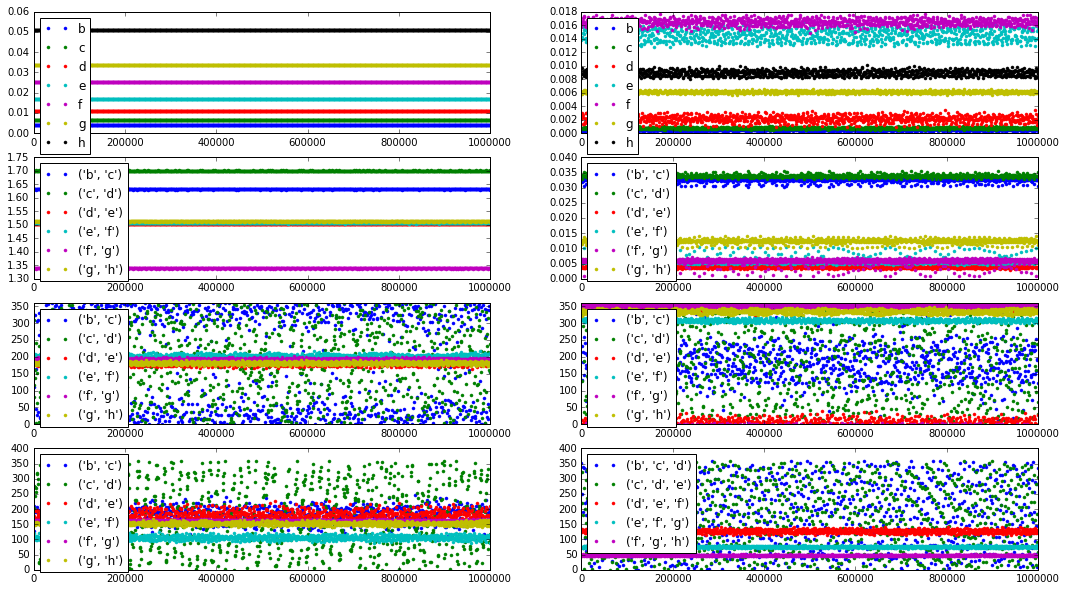

In [108]:
%%time
import os
import re

path = '7pdissipation/data/'
simID = 9
for filename in os.listdir(path):
    result = re.search('IC{0}K(.*)mag(.*)taue(.*).bin'.format(simID), filename)
    if result:
        if "rebx" not in filename:
            print(filename)
            sa = rebound.SimulationArchive(path+filename)
            print("K={0}".format(result.group(1)))
            print("mag={0}".format(result.group(2)))
            print("taue={0}".format(result.group(3)))
            break
        
plot(sa,planets,resonances,threebodyresonances);

In [98]:
for i in range(1,sim.N-1):
    print(sim.particles[i+1].P/sim.particles[i].P)

1.6325675457153341
1.699478942756657
1.5032447285277226
1.4996072612171163
1.3333540687030496
1.3347562869647502


In [92]:
for p in sim.particles[1:]:
    print(p.params["tides_synchronous_tau_e"])

-31622776.60168379
-547501045.7220055
-2052467528.249413
-12990371135.877892
-131842465345.37688
-700997769003.9103
-663995849016.207
